In [1]:
# ============================
# 1. MOUNT DI GOOGLE DRIVE
# ============================

# Importo il modulo drive fornito da Colab per interagire con Google Drive.
from google.colab import drive

# Monta Google Drive nella directory locale /content/drive.
# force_remount=True forza un remount anche se era già montato.
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
# =========================================
# 2. CONFIGURAZIONE GLOBALE + IMPORT & DEVICE
# =========================================

# Dizionario di iperparametri e costanti globali.
global_var = {
    # PARAMETRI DI CARICAMENTO / PREPROCESSING DEI DATI:
    "batch_size": 128,        # Campioni per batch (aumentato per A100).
    "n_workers": 2,           # Worker del DataLoader per prefetch/parallelo.
    "max_seq_len": 512,      # Lunghezza massima; testi lunghi troncati, corti paddati.

    # PARAMETRI DEL MODELLO (TextCNN):
    "embedding_dim": 300,             # Dimensione embedding.
    "cnn_num_filters": 400,           # Numero filtri per ciascuna conv.
    "cnn_kernel_sizes": [3, 4, 5, 7], # Kernel multipli (anche 7 per contesti lunghi).
    "mlp_hidden_dim": 400,            # Dimensione layer MLP nascosto.
    "output_dim": 2,                  # Classi: 0 = HUMAN, 1 = GenAI.
    "dropout": 0.25,                   # Dropout per regolarizzazione.

    # PARAMETRI DI TRAINING:
    "learning_rate": 1e-3,            # LR più piccolo per training stabile.
    "epochs": 10,                     # Numero massimo epoche (con early stopping).
    "weight_decay": 1e-5,             # Penalità L2.
    "label_smoothing": 0.0,          # Label smoothing per CrossEntropy.

    # VALIDAZIONE / EARLY STOP:
    "val_size": 0.2,                  # (Nel setup attuale non splittiamo il train: usiamo direttamente DEV come VAL.)
    "patience": 5,                    # Early stopping se non migliora per N epoche.

    # CONTROLLO GLOBALE DELLA SOGLIA DI DECISIONE:
    # - Se None  → usa la soglia ottimizzata su VALIDATION (grid search).
    # - Se float → override globale (es: 0.35 per dtEN, 0.40 per ART&MH, ecc.).
    # CAMBIA SOLO QUI PER MODIFICARE LA SOGLIA DI DECISIONE.
    "DECISION_THRESHOLD_OVERRIDE": None
}

# --------------------
# IMPORT STANDARD
# --------------------
import os
import math
import copy
import re
import random
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

# --------------------
# IMPORT PYTORCH
# --------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torch.amp import autocast, GradScaler

# --------------------
# IMPORT SCIKIT-LEARN
# --------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

# --------------------
# SELEZIONE DEL DEVICE (CPU / GPU, preferendo A100 se presente)
# --------------------
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)              # Nome della prima GPU disponibile.
    if "A100" in device_name:
        device = torch.device("cuda:0")                      # Se troviamo A100, usiamo quella.
        print(f"[LOG] A100 GPU detected and selected: {device_name} ({device})")
    else:
        device = torch.device("cuda:0")                      # Altrimenti usiamo comunque la prima CUDA.
        print(f"[LOG] CUDA GPU detected (not A100): {device_name} ({device})")
else:
    device = torch.device("cpu")                             # Fallback CPU.
    print(f"[LOG] No CUDA GPU available. Selected device → {device}")

[LOG] A100 GPU detected and selected: NVIDIA A100-SXM4-40GB (cuda:0)


In [3]:
# =========================================
# 3. UTILITY: COLLATED, TOKENIZER, VOCAB, DATASET, SEED
# =========================================

# Token speciali riservati: <pad> (id 0) e <unk> (id 1).
PAD, UNK = "<pad>", "<unk>"

# Regex per tokenizzare parole alfanumeriche (Unicode) ignorando punteggiatura.
_token_re = re.compile(r"\b\w+\b", flags=re.UNICODE)

def basic_tokenizer(text: str):
    """
    Tokenizzazione minimale basata su regex:
    - converte in lowercase
    - estrae sequenze alfanumeriche come token
    """
    return _token_re.findall(str(text).lower())

def build_vocab(text_iter, min_freq: int = 1):
    """
    Costruisce il vocabolario a partire da un iterabile di testi.
    - text_iter: iterabile di stringhe (una per riga / documento)
    - min_freq: frequenza minima per includere un token nel vocabolario
    """
    counter = Counter()                     # Multinsieme delle frequenze dei token.
    for line in text_iter:                  # Scorre tutti i testi una volta.
        counter.update(basic_tokenizer(line))

    # Inizializza il vocabolario con i token speciali PAD (0) e UNK (1).
    vocab = {PAD: 0, UNK: 1}
    for tok, c in counter.most_common():    # Aggiunge i token in ordine di frequenza decrescente.
        if c >= min_freq:                   # Filtra i token troppo rari.
            vocab[tok] = len(vocab)         # Assegna un nuovo ID progressivo.
    return vocab

def collate_trim(batch):
    """
    Collate function personalizzata per NLP con sequenze padded.
    Input: lista di tuple (x: tensor [T_max], y: int)

    - Calcola la lunghezza reale di ciascuna sequenza (contando token != 0).
    - Tronca tutte le sequenze del batch alla max lunghezza effettiva L_batch.
    - Restituisce:
        xs_trim: tensor [B, L_batch]
        ys:      tensor [B]
    """
    # Unzip del batch in liste di tensori (xs) e label (ys).
    xs, ys = zip(*batch)

    # Lunghezze reali per ogni sequenza (numero di token != PAD).
    lens = [int((x != 0).sum().item()) for x in xs]

    # Lunghezza massima reale nel batch (minimo 1).
    Lb = max(1, max(lens)) if lens else 1

    # Troncamento dinamico di ogni sequenza alla lunghezza Lb.
    xs_trim = torch.stack([x[:Lb] for x in xs])

    # Stack delle label in un unico tensore [B].
    ys = torch.stack(ys)
    return xs_trim, ys

def make_loader(dataset, batch_size, shuffle):
    """
    Costruisce un DataLoader con:
      - collate_fn = collate_trim (padding dinamico a livello di batch)
      - pin_memory per trasferimenti GPU più rapidi (se device CUDA)
      - persistent_workers + prefetch_factor se n_workers > 0
    """
    kwargs = {}
    if global_var["n_workers"] > 0:
        kwargs["persistent_workers"] = True     # Mantiene i worker vivi tra un'epoca e l'altra.
        kwargs["prefetch_factor"] = 4           # Numero di batch prefetchati per worker.

    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=global_var["n_workers"],
        pin_memory=(device.type == "cuda"),
        collate_fn=collate_trim,
        **kwargs
    )

class TextDataset(Dataset):
    """
    Dataset testuale minimo in stile PyTorch.

    Richiede un CSV con almeno:
      - colonna 'text'
      - colonna 'label'
    """
    def __init__(self, csv_path: str, vocab: dict | None = None, min_freq: int = 1):
        # Carica il CSV in un DataFrame.
        df = pd.read_csv(csv_path)

        # Estrae la colonna 'text' come lista di stringhe.
        self.texts  = df["text"].astype(str).tolist()

        # Estrae la colonna 'label' come lista di interi.
        self.labels = df["label"].astype(int).tolist()

        # Se viene passato un vocabolario esterno, lo usa; altrimenti lo costruisce da zero sui testi.
        self.vocab  = vocab or build_vocab(self.texts, min_freq = 5)

    def __len__(self):
        # Ritorna il numero di campioni nel dataset.
        return len(self.labels)

    def encode(self, text: str):
        """
        Converte una stringa in un tensore di ID token:
          1) Tokenizza in lowercase con basic_tokenizer.
          2) Converte ogni token in id (UNK se non presente in vocab).
          3) Tronca a max_seq_len.
          4) Padda con PAD fino a max_seq_len.
        """
        # Tokenizzazione + mapping token→id, con fallback a UNK.
        ids = [self.vocab.get(t, self.vocab[UNK])
               for t in basic_tokenizer(text)][: global_var["max_seq_len"]]

        # Padding fino alla lunghezza fissa max_seq_len.
        ids += [self.vocab[PAD]] * (global_var["max_seq_len"] - len(ids))

        # Restituisce un tensore long di dimensione [T].
        return torch.tensor(ids, dtype=torch.long)

    def __getitem__(self, idx):
        """
        Restituisce la coppia (input_ids, label) per l'indice idx.
        """
        return self.encode(self.texts[idx]), torch.tensor(self.labels[idx])

# --------------------
# SEEDING PER RIPRODUCIBILITÀ
# --------------------
def seed_everything(seed=42):
    """
    Fissa i seed di:
      - Python random
      - NumPy
      - PyTorch (CPU e CUDA)
    e forza cuDNN in modalità deterministica per risultati ripetibili.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Applica il seed iniziale.
seed_everything(42)

In [4]:
# ==============================================================
# 4. CARICAMENTO DATI, CREAZIONE TRAIN / VAL / TEST, DATASET & LOADER
# ==============================================================

# Base path su Drive dove risiedono i CSV (adatta se diverso).
BASE = "/content/drive/MyDrive/TESI-Classificazione/MIO"

# Percorsi dei dataset originali (TRAIN completo e DEV completo).
TRAIN_CSV_ORIG = f"{BASE}/en_train_full.csv"   # Usato per training + vocab.
DEV_CSV_ORIG   = f"{BASE}/en_dev_full.csv"     # Da cui estrarre VAL e TEST(60 ID).

import tempfile  # Per creare file temporanei compatibili con TextDataset.

# Carica i DataFrame grezzi.
df_train = pd.read_csv(TRAIN_CSV_ORIG)
df_dev   = pd.read_csv(DEV_CSV_ORIG)

# ===== BILANCIAMENTO DEL TRAIN (downsampling della classe maggioritaria) =====
# 0 = HUMAN, 1 = GenAI
n_h = (df_train["label"] == 0).sum()
n_g = (df_train["label"] == 1).sum()
print("[BEFORE BALANCE] HUMAN:", n_h, "GenAI:", n_g)

# numero minimo per pareggiare
n_min = min(n_h, n_g)

# prendo n_min esempi per ciascuna classe
df_h_bal = df_train[df_train["label"] == 0].sample(n_min, random_state=42)
df_g_bal = df_train[df_train["label"] == 1].sample(n_min, random_state=42)

# unisco e mescolo
df_train = pd.concat([df_h_bal, df_g_bal], axis=0)\
             .sample(frac=1, random_state=42)\
             .reset_index(drop=True)

print("[AFTER BALANCE] HUMAN:", (df_train["label"] == 0).sum(),
      "GenAI:", (df_train["label"] == 1).sum())
print("[AFTER BALANCE] TRAIN rows =", len(df_train))
# ===== FINE BILANCIAMENTO =====


# Lista dei 60 ID da usare come TEST (come da specifica).
TEST_IDS = [
    1785,6558,6958,7814,8393,22792,24314,24563,25355,26795,26870,29186,36581,40760,
    41855,52126,56445,57316,57790,58514,60992,64197,69344,72099,72844,72926,88238,
    89196,90169,94106,99598,109977,110606,110787,117759,132477,142851,142966,147127,
    154474,154796,157817,158265,167622,170365,177393,183015,183849,187702,193068,
    194164,194395,198917,200148,211244,212189,222169,227883,233881,250929
]
# Rimozione di eventuali duplicati preservando l'ordine.
TEST_IDS = list(dict.fromkeys(TEST_IDS))

def pick_test_rows_from_dev(df_dev, ids):
    """
    Seleziona le righe da df_dev corrispondenti alla lista di ID:
      1) Prova a usare la colonna 'id' (come valore o come numerico).
      2) Altrimenti usa gli indici di riga 0-based o 1-based.
    Restituisce:
      - df_test_sel: DataFrame con le righe di TEST
      - used_idx: indici originali usati
      - how: descrizione del metodo usato
    """
    # 1) Se esiste colonna 'id', prova match diretto su 'id'.
    if "id" in df_dev.columns:
        m = df_dev["id"].isin(ids)
        if m.sum() < len(ids):
            # Se non li trova tutti, prova a convertire 'id' in numerico e ripetere.
            try:
                m = m | pd.to_numeric(df_dev["id"], errors="coerce").isin(ids)
            except Exception:
                pass
        if int(m.sum()) > 0:
            return df_dev.loc[m].copy(), df_dev.index[m], "by id"

    # 2) Fallback su indici di riga (0-based / 1-based).
    m0 = df_dev.index.isin(ids)
    m1 = df_dev.index.isin([i - 1 for i in ids])  # ipotesi: ids sono 1-based.

    if int(m0.sum()) >= int(m1.sum()):
        return df_dev.loc[m0].copy(), df_dev.index[m0], "by 0-based row index"
    else:
        return df_dev.loc[m1].copy(), df_dev.index[m1], "by 1-based row index (id-1)"

# Applica la selezione TEST sui 60 ID.
df_test_sel, used_idx, how = pick_test_rows_from_dev(df_dev, TEST_IDS)
assert len(df_test_sel) > 0, "Nessuna riga selezionata per il TEST (controlla gli ID)."

# df_test = sottoinsieme DEV per i 60 ID; df_val = DEV rimanente.
df_test = df_test_sel.reset_index(drop=True)
df_val  = df_dev.drop(used_idx).reset_index(drop=True)

print(f"[LOG] TEST selection mode: {how}")
print(f"[CHECK] TRAIN rows = {len(df_train)}")
print(f"[CHECK] DEV rows   = {len(df_dev)}")
print(f"[CHECK] VAL rows   = {len(df_val)}")
print(f"[CHECK] TEST rows  = {len(df_test)}")

# Salva i DataFrame in CSV temporanei (compatibili con TextDataset).
with tempfile.NamedTemporaryFile(suffix=".csv", delete=False) as tmp_train_file:
    df_train.to_csv(tmp_train_file.name, index=False)
    TRAIN_CSV = tmp_train_file.name   # Percorso temporaneo per TRAIN.

with tempfile.NamedTemporaryFile(suffix=".csv", delete=False) as tmp_val_file:
    df_val.to_csv(tmp_val_file.name, index=False)
    EVAL_CSV = tmp_val_file.name     # Percorso temporaneo per VALIDATION.

with tempfile.NamedTemporaryFile(suffix=".csv", delete=False) as tmp_test_file:
    df_test.to_csv(tmp_test_file.name, index=False)
    TEST_CSV = tmp_test_file.name    # Percorso temporaneo per TEST(60).

# 1) Vocabolario SOLO sul TRAIN (evita leakage da VAL/TEST).
full_train = TextDataset(TRAIN_CSV, min_freq=3)
vocab = full_train.vocab
print(f"[LOG] Vocabulary size (from TRAIN): {len(vocab)}")

# 2) Dataset di VALIDATION e TEST riusando il vocabolario del TRAIN.
eval_dataset = TextDataset(EVAL_CSV, vocab=vocab)
test_dataset = TextDataset(TEST_CSV, vocab=vocab)

# 3) DataLoader per TRAIN / VAL / TEST.
train_loader = make_loader(full_train,   global_var["batch_size"], shuffle=True)
val_loader   = make_loader(eval_dataset, global_var["batch_size"], shuffle=False)
test_loader  = make_loader(test_dataset, global_var["batch_size"], shuffle=False)

# Sanity check dimensioni dataset.
assert len(eval_dataset) == len(df_val),  f"Mi aspetto {len(df_val)} in VALIDATION"
assert len(test_dataset) == len(df_test), f"Mi aspetto {len(df_test)} in TEST"

print(f"[CHECK] VALIDATION rows (loader) = {len(eval_dataset)}")
print(f"[CHECK] TEST rows (loader)       = {len(test_dataset)}")

# Manteniamo anche una variabile base_vocab riutilizzabile in valutazione.
base_vocab = vocab

[BEFORE BALANCE] HUMAN: 229209 GenAI: 381467
[AFTER BALANCE] HUMAN: 229209 GenAI: 229209
[AFTER BALANCE] TRAIN rows = 458418
[LOG] TEST selection mode: by 0-based row index
[CHECK] TRAIN rows = 458418
[CHECK] DEV rows   = 261849
[CHECK] VAL rows   = 261789
[CHECK] TEST rows  = 60
[LOG] Vocabulary size (from TRAIN): 148616
[CHECK] VALIDATION rows (loader) = 261789
[CHECK] TEST rows (loader)       = 60


[LOG] Distribuzione train: Counter({1: 229209, 0: 229209}) imbalance= 0.0
[LOG] Uso CrossEntropyLoss SENZA class weights


Epoch 1/10 [train]:   0%|          | 0/3582 [00:00<?, ?batch/s]

/usr/local/lib/python3.12/dist-packages/torch/backends/cuda/__init__.py:131: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return torch._C._get_cublas_allow_tf32()


[LOG] Ep1: train=0.6860 | val=0.6901


Epoch 2/10 [train]:   0%|          | 0/3582 [00:00<?, ?batch/s]

[LOG] Ep2: train=0.6932 | val=0.6932


Epoch 3/10 [train]:   0%|          | 0/3582 [00:00<?, ?batch/s]

[LOG] Ep3: train=0.6931 | val=0.6935


Epoch 4/10 [train]:   0%|          | 0/3582 [00:00<?, ?batch/s]

[LOG] Ep4: train=0.6932 | val=0.6927


Epoch 5/10 [train]:   0%|          | 0/3582 [00:00<?, ?batch/s]

[LOG] Ep5: train=0.6932 | val=0.6935


Epoch 6/10 [train]:   0%|          | 0/3582 [00:00<?, ?batch/s]

[LOG] Ep6: train=0.6932 | val=0.6929
[LOG] Early stop a epoca 6 (best val=0.6901).


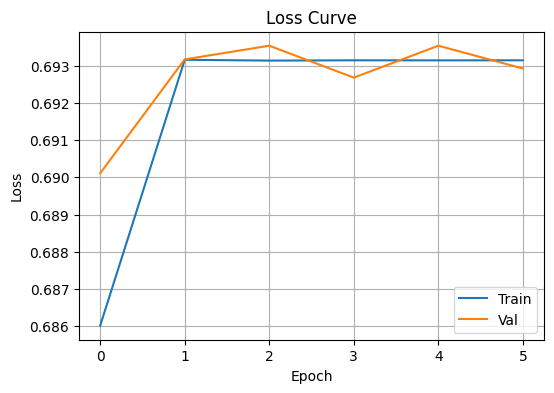

In [5]:
# =========================================
# 5. MODELLO TEXTCNN, LOSS, OPTIMIZER, TRAINING
# =========================================

class TextCNN(nn.Module):
    """
    TextCNN con:
      - embedding
      - Conv1D parallele (kernel multipli)
      - global max pooling
      - MLP finale con Dropout
    """
    def __init__(self,
                 vocab_size: int,
                 emb_dim: int,
                 num_filters: int,
                 kernel_sizes: list[int],
                 mlp_hidden_dim: int,
                 num_classes: int,
                 dropout: float = 0.2,
                 padding_idx: int = 0):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx)

        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=emb_dim,
                out_channels=num_filters,
                kernel_size=k
            )
            for k in kernel_sizes
        ])

        conv_out_dim = num_filters * len(kernel_sizes)
        self.fc1 = nn.Linear(conv_out_dim, mlp_hidden_dim)
        self.fc2 = nn.Linear(mlp_hidden_dim, num_classes)
        self.drop = nn.Dropout(dropout)
        self.act  = nn.ReLU()

    def forward(self, x):
        emb = self.embedding(x)        # [B, T, E]
        emb = emb.transpose(1, 2)      # [B, E, T]

        pooled_outputs = []
        for conv in self.convs:
            h = self.act(conv(emb))    # [B, F, T']
            p = torch.amax(h, dim=2)   # [B, F]
            pooled_outputs.append(p)

        feat = torch.cat(pooled_outputs, dim=1)  # [B, F * n_kernels]
        h = self.drop(self.act(self.fc1(feat)))
        h = self.drop(h)
        logits = self.fc2(h)
        return logits


# --------------------
# LOSS (con label smoothing) SENZA class weights (forzato)
# --------------------
cnt = Counter(full_train.labels)
tot = len(full_train)
imbalance = abs(cnt[0] - cnt[1]) / max(1, tot)
print("[LOG] Distribuzione train:", cnt, "imbalance=", imbalance)

# Forziamo CrossEntropy standard con label smoothing,
# senza pesi di classe (per evitare che spinga TROPPO su GenAI).
loss_fn = nn.CrossEntropyLoss()
print("[LOG] Uso CrossEntropyLoss SENZA class weights")

# --------------------
# ISTANZIA MODELLO, OPTIMIZER, SCHEDULER
# --------------------
model = TextCNN(
    vocab_size=len(vocab),
    emb_dim=global_var["embedding_dim"],
    num_filters=global_var["cnn_num_filters"],
    kernel_sizes=global_var["cnn_kernel_sizes"],
    mlp_hidden_dim=global_var["mlp_hidden_dim"],
    num_classes=global_var["output_dim"],
    dropout=global_var["dropout"],
    padding_idx=0
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=global_var["learning_rate"],
    weight_decay=global_var["weight_decay"]
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)

# --------------------
# FUNZIONE DI TRAINING CON AMP, SCHEDULER, EARLY STOPPING
# --------------------
def train_amp(model, train_loader, val_loader, epochs, patience=5):
    """
    Loop di training con:
      - AMP (automatic mixed precision)
      - gradient clipping
      - ReduceLROnPlateau scheduler
      - early stopping basato su val-loss
    """
    scaler = GradScaler('cuda', enabled=(device.type == "cuda"))
    history = {"train": [], "val": []}
    best_val = math.inf
    best_state = None
    bad_epochs = 0

    try:
        if hasattr(torch, "compile"):
            model = torch.compile(model)
    except Exception:
        pass

    for ep in range(epochs):
        model.train()
        running_loss = 0.0

        pbar = tqdm(train_loader, unit="batch", desc=f"Epoch {ep+1}/{epochs} [train]")
        for bx, by in pbar:
            bx = bx.to(device, non_blocking=True)
            by = by.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)

            # ✅ FIX: niente device_type per autocast (stai usando torch.cuda.amp.autocast)
            with autocast('cuda', enabled=(device.type == "cuda")):
                logits = model(bx)
                loss = loss_fn(logits, by)

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            pbar.set_postfix(loss=running_loss / (pbar.n + 1))

        # VALIDAZIONE
        model.eval()
        val_loss = 0.0
        # ✅ FIX anche qui: niente device_type
        with torch.inference_mode(), autocast('cuda', enabled=(device.type == "cuda")):
            for bx, by in val_loader:
                bx = bx.to(device, non_blocking=True)
                by = by.to(device, non_blocking=True)
                logits = model(bx)
                val_loss += loss_fn(logits, by).item()

        val_loss /= max(1, len(val_loader))
        history["train"].append(running_loss / max(1, len(train_loader)))
        history["val"].append(val_loss)

        print(f"[LOG] Ep{ep+1}: train={history['train'][-1]:.4f} | val={val_loss:.4f}")

        scheduler.step(val_loss)

        if val_loss < best_val - 1e-4:
            best_val = val_loss
            best_state = copy.deepcopy(model.state_dict())
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                print(f"[LOG] Early stop a epoca {ep+1} (best val={best_val:.4f}).")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return history

# --------------------
# ESECUZIONE TRAINING
# --------------------
history = train_amp(
    model, train_loader, val_loader,
    epochs=global_var["epochs"],
    patience=global_var["patience"]
)

# --------------------
# PLOT DELLA LOSS
# --------------------
plt.figure(figsize=(6, 4))
plt.plot(history["train"], label="Train")
plt.plot(history["val"],   label="Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# ==================================================
# 6. FUNZIONI DI VALUTAZIONE, TEMPERATURE SCALING, TUNING SOGLIA
# ==================================================

def evaluate_loader(model, loader, label_names=("HUMAN", "GenAI"),
                    temperature=1.0, threshold=None, plot_cm=False, title_suffix=""):
    """
    Valuta il modello su un DataLoader.
    Opzioni:
      - temperature: scaling dei logits (T) per calibrazione probabilità.
      - threshold: soglia manuale sulla probabilità della classe 1 (se None → argmax).
      - plot_cm: se True, mostra heatmap della confusion matrix.
    Ritorna:
      - report: dict in formato classification_report (output_dict=True).
      - cm: matrice di confusione numpy.
    """
    model.eval()
    y_true, y_pred = [], []

    with torch.inference_mode():
        for bx, by in loader:
            # Forward + temperature scaling.
            logits = model(bx.to(device)) / temperature

            if threshold is None:
                # Predizione classica via argmax sui logits.
                pred = logits.argmax(1).cpu().numpy()
            else:
                # Probabilità della classe 1 (GenAI).
                p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
                # Predizione binaria via soglia manuale.
                pred = (p1 >= threshold).astype(int)

            # Accumula predizioni e label vere.
            y_pred.extend(pred.tolist())
            y_true.extend(by.cpu().numpy().tolist())

    # Report di classificazione (per classe + macro/micro avg).
    report = classification_report(
        y_true, y_pred,
        target_names=list(label_names),
        output_dict=True,
        digits=4
    )

    # Matrice di confusione.
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix se richiesto.
    if plot_cm:
        plt.figure(figsize=(5, 4))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=label_names,
            yticklabels=label_names
        )
        ttl = "Confusion Matrix" + (f" {title_suffix}" if title_suffix else "")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(ttl)
        plt.tight_layout()
        plt.show()

    return report, cm

def evaluate_csv(model, csv_path, vocab, batch_size=None, n_workers=None,
                 label_names=("HUMAN", "GenAI"), temperature=1.0, threshold=None,
                 plot_cm=False, title_suffix=""):
    """
    Wrapper di valutazione che:
      - costruisce un TextDataset a partire da un CSV
      - costruisce un DataLoader (no shuffle)
      - chiama evaluate_loader
    """
    batch_size = batch_size or global_var["batch_size"]

    # Costruisce dataset con vocabolario fissato (quello del TRAIN).
    ds = TextDataset(csv_path, vocab=vocab)

    # DataLoader per valutazione (no shuffle).
    dl = make_loader(ds, batch_size=batch_size, shuffle=False)

    # Chiamata alla funzione di valutazione generica.
    rep, cm = evaluate_loader(
        model, dl, label_names=label_names,
        temperature=temperature, threshold=threshold,
        plot_cm=plot_cm, title_suffix=title_suffix
    )
    return rep, cm, len(ds)

def calibrate_temperature(model, val_loader, device):
    """
    Calibra la temperatura T sui dati di VALIDATION minimizzando la CrossEntropy
    tramite ottimizzazione di logT con L-BFGS.
    """
    model.eval()
    logits_list, labels_list = [], []

    # Accumula logits e label su tutta la VALIDATION.
    with torch.inference_mode():
        for bx, by in val_loader:
            logits_list.append(model(bx.to(device)))      # [B, C]
            labels_list.append(by.to(device))             # [B]

    # Concatena su dimensione batch: [N, C] e [N].
    logits = torch.cat(logits_list)
    labels = torch.cat(labels_list)

    # Loss di riferimento per la calibrazione (sui logits non normalizzati).
    nll = nn.CrossEntropyLoss()

    # Parametro logT per assicurare T > 0 (T = exp(logT)).
    logT = torch.tensor(0.0, device=device, requires_grad=True)

    # Ottimizzatore L-BFGS su un unico parametro logT.
    optimizer_T = torch.optim.LBFGS([logT], lr=0.5, max_iter=50)

    def closure():
        optimizer_T.zero_grad()
        T = torch.exp(logT)
        loss = nll(logits / T, labels)
        loss.backward()
        return loss

    # Esegue le iterazioni di L-BFGS.
    optimizer_T.step(closure)

    # Estrae la temperatura ottimale come float.
    T = torch.exp(logT).item()
    print(f"[VAL] temperatura ottima T={T:.3f}")
    return T

def tune_threshold_on_val(model, val_loader, device, temperature=1.0, metric="balanced_accuracy"):
    """
    Esegue una grid search sulla soglia t in [0.05, 0.95] per massimizzare:
      - balanced_accuracy (default) oppure
      - F1 macro (se metric='f1_macro')
    sulla VALIDATION, usando le probabilità calibrate con T.
    """
    model.eval()
    y_true_val, y_prob_val = [], []

    # Calcola p(classe=1) su tutta la VALIDATION.
    with torch.inference_mode():
        for bx, by in val_loader:
            logits = model(bx.to(device)) / temperature
            p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
            y_prob_val.extend(p1.tolist())
            y_true_val.extend(by.numpy().tolist())

    y_true_val = np.array(y_true_val)
    y_prob_val = np.array(y_prob_val)

    best_t, best_score = 0.5, -1.0

    # Grid search su 19 soglie equispaziate in [0.05, 0.95].
    for t in np.linspace(0.05, 0.95, 19):
        y_hat = (y_prob_val >= t).astype(int)

        if metric == "balanced_accuracy":
            score = balanced_accuracy_score(y_true_val, y_hat)
        else:
            score = f1_score(y_true_val, y_hat, average="macro")

        if score > best_score:
            best_score, best_t = score, t

    # Report finale su VALIDATION per la soglia migliore.
    y_hat = (y_prob_val >= best_t).astype(int)
    print(
        f"[VAL] soglia ottima t*={best_t:.2f} "
        f"(bal_acc={balanced_accuracy_score(y_true_val, y_hat):.3f}, "
        f"f1_macro={f1_score(y_true_val, y_hat, average='macro'):.3f}, "
        f"acc={accuracy_score(y_true_val, y_hat):.3f})"
    )

    return best_t

[VAL] temperatura ottima T=0.929
[VAL] soglia ottima t*=0.05 (bal_acc=0.500, f1_macro=0.385, acc=0.626)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


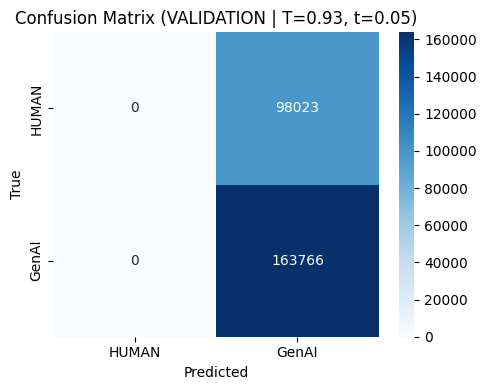


[LOG] Validation su tmp6gg0kb2f.csv — campioni: 261789
Accuracy: 0.6256  |  F1 macro: 0.3848  |  Precision macro: 0.3128  |  Recall macro: 0.5000
[CHECK] VALIDATION rows = 261789
[CHECK] TEST rows       = 60


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


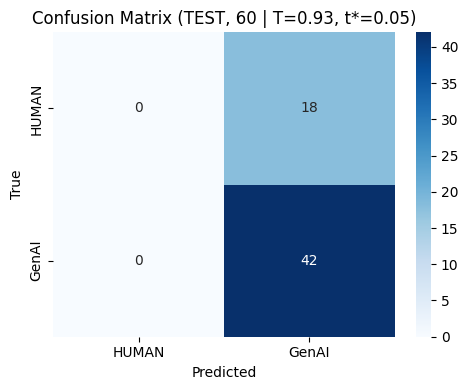


[LOG] Test su tmpv28f19zy.csv — campioni: 60
Accuracy: 0.7000  |  F1 macro: 0.4118  |  Precision macro: 0.3500  |  Recall macro: 0.5000
[INFO] TEST — mostro tutte le 60 righe (errori in alto). Il file completo viene salvato su Drive.



,id,text,true,pred,prob_genai_it,correct
2,1d9f9c17-8260-43fd-8d32-c7570d4e6287,"In terms of written sources in the Medieval period , most of them are from higher - up government sources , such as treaties , speeches from monarchs or tre...",HUMAN,GenAI,"0,5064047",✗
7,026b8a68-9a06-450d-bf45-1b8ff4c2691f,"Carpet-weaving is historically a major traditional profession for the majority of Armenian women, including many Armenian families. Prominent Karabakh carpe...",HUMAN,GenAI,"0,5064047",✗
12,fd8959f1-293c-4dc1-87de-39e824225cb6,"I love spicy food pretty much because I enjoy the taste . I would n't enjoy something so hot that I actually consider it "" pain "" though , I want to break a...",HUMAN,GenAI,"0,5064047",✗
18,b816ff7b-c182-4a07-9fef-e62dbaf08858,"Well in terms of governing , the economy is integral , but its not the only thing that matters . In addition , because the president has economists as advis...",HUMAN,GenAI,"0,5064047",✗
20,3709e3cc-77b8-4913-ae61-24544e061143,"We hadn't been to Macayo's for awhile and I remember them being better than last night. Both of our foods, bean burro and chimi, were completely tasteless. ...",HUMAN,GenAI,"0,5064047",✗
26,15459941-6257-43d9-a419-bd7e76de1785,"José Mariano de la Cruz de la Riva Agüero y Sánchez Boquete, Marquess of Montealegre de Aulestia (3 May 1783 – 21 May 1858) was a soldier, politician, and h...",HUMAN,GenAI,"0,5064047",✗
28,ddf135f8-7062-4ded-99a5-d47552135ecb,In the conservative camp There is this idea that most mainstream news sources tend to side with liberal ideologies . It basically refers to the big news com...,HUMAN,GenAI,"0,5064047",✗
29,ad236fe9-a338-4076-83a5-d43ec5611f74,"The earliest surviving written work on the subject of architecture is De architectura, by the Roman architect Vitruvius in the early 1st century AD. Accordi...",HUMAN,GenAI,"0,5064047",✗
33,da9586a0-d52e-47d5-9ffe-dcdf0d0e6520,"This study points to a similar mode of action for the two viral proteins, suggesting that anti-viral strategy that targets the viral-induced membrane fusion...",HUMAN,GenAI,"0,5064047",✗
34,1129f2ab-b279-4093-bfb4-b9ec5f2077cc,"Individual hair follicles determine the attributes of each strand of hair , aberrations of conditions ( increased testosterone at that area , UV damage , et...",HUMAN,GenAI,"0,5064047",✗


[LOG] File completo salvato in: /content/drive/MyDrive/TESI-Classificazione/MIO/test_predictions_dtEN_T0.93_t0.05.csv

[INFO] Errori totali (TEST): 18



,id,text,true,pred,prob_genai_it,correct
2,1d9f9c17-8260-43fd-8d32-c7570d4e6287,"In terms of written sources in the Medieval period , most of them are from higher - up government sources , such as treaties , speeches from monarchs or tre...",HUMAN,GenAI,"0,5064047",✗
7,026b8a68-9a06-450d-bf45-1b8ff4c2691f,"Carpet-weaving is historically a major traditional profession for the majority of Armenian women, including many Armenian families. Prominent Karabakh carpe...",HUMAN,GenAI,"0,5064047",✗
12,fd8959f1-293c-4dc1-87de-39e824225cb6,"I love spicy food pretty much because I enjoy the taste . I would n't enjoy something so hot that I actually consider it "" pain "" though , I want to break a...",HUMAN,GenAI,"0,5064047",✗
18,b816ff7b-c182-4a07-9fef-e62dbaf08858,"Well in terms of governing , the economy is integral , but its not the only thing that matters . In addition , because the president has economists as advis...",HUMAN,GenAI,"0,5064047",✗
20,3709e3cc-77b8-4913-ae61-24544e061143,"We hadn't been to Macayo's for awhile and I remember them being better than last night. Both of our foods, bean burro and chimi, were completely tasteless. ...",HUMAN,GenAI,"0,5064047",✗
26,15459941-6257-43d9-a419-bd7e76de1785,"José Mariano de la Cruz de la Riva Agüero y Sánchez Boquete, Marquess of Montealegre de Aulestia (3 May 1783 – 21 May 1858) was a soldier, politician, and h...",HUMAN,GenAI,"0,5064047",✗
28,ddf135f8-7062-4ded-99a5-d47552135ecb,In the conservative camp There is this idea that most mainstream news sources tend to side with liberal ideologies . It basically refers to the big news com...,HUMAN,GenAI,"0,5064047",✗
29,ad236fe9-a338-4076-83a5-d43ec5611f74,"The earliest surviving written work on the subject of architecture is De architectura, by the Roman architect Vitruvius in the early 1st century AD. Accordi...",HUMAN,GenAI,"0,5064047",✗
33,da9586a0-d52e-47d5-9ffe-dcdf0d0e6520,"This study points to a similar mode of action for the two viral proteins, suggesting that anti-viral strategy that targets the viral-induced membrane fusion...",HUMAN,GenAI,"0,5064047",✗
34,1129f2ab-b279-4093-bfb4-b9ec5f2077cc,"Individual hair follicles determine the attributes of each strand of hair , aberrations of conditions ( increased testosterone at that area , UV damage , et...",HUMAN,GenAI,"0,5064047",✗


In [7]:
# ==================================================
# 7. CALIBRAZIONE SU VALIDATION, VALUTAZIONE FINALE E SALVATAGGIO CSV TEST
# ==================================================

# Per sicurezza, se per qualche motivo val_loader non esistesse, usa test_loader come fallback.
try:
    val_loader
except NameError:
    val_loader = test_loader

# -------- 7.1 Calibrazione temperatura T su VALIDATION --------
T_eval = calibrate_temperature(model, val_loader, device)

# -------- 7.2 Tuning soglia t* su VALIDATION (usando T_eval) --------
t_eval_star = tune_threshold_on_val(
    model, val_loader, device,
    temperature=T_eval,
    metric="f1_macro"   # puoi cambiare in "balanced_accuracy" se preferisci.
)

# -------- 7.3 Override manuale della soglia, se richiesto --------
# Se vuoi una soglia fissa (es. 0.35), basta impostarla in global_var["DECISION_THRESHOLD_OVERRIDE"].
if global_var.get("DECISION_THRESHOLD_OVERRIDE") is not None:
    t_eval_star = float(global_var["DECISION_THRESHOLD_OVERRIDE"])
    print(f"[INFO] Soglia di decisione OVERRIDE applicata: t={t_eval_star:.2f}")

# Vocabolario da usare in valutazione (lo stesso del train).
vocab_for_eval = base_vocab

# -------- 7.4 Valutazione su VALIDATION (report + CM) --------
rep_val, cm_val, n_val = evaluate_csv(
    model, EVAL_CSV, vocab=vocab_for_eval,
    label_names=("HUMAN", "GenAI"),
    temperature=T_eval, threshold=t_eval_star,
    plot_cm=True, title_suffix=f"(VALIDATION | T={T_eval:.2f}, t={t_eval_star:.2f})"
)

print(f"\n[LOG] Validation su {os.path.basename(EVAL_CSV)} — campioni: {n_val}")
print(
    f"Accuracy: {rep_val['accuracy']:.4f}  |  "
    f"F1 macro: {rep_val['macro avg']['f1-score']:.4f}  |  "
    f"Precision macro: {rep_val['macro avg']['precision']:.4f}  |  "
    f"Recall macro: {rep_val['macro avg']['recall']:.4f}"
)

# -------- 7.5 Sanity check esistenza file di VALIDATION e TEST --------
assert os.path.exists(EVAL_CSV), f"File di VALIDATION non trovato: {EVAL_CSV}"
assert os.path.exists(TEST_CSV),  f"File di TEST non trovato: {TEST_CSV}"
print(f"[CHECK] VALIDATION rows = {len(pd.read_csv(EVAL_CSV))}")
print(f"[CHECK] TEST rows       = {len(pd.read_csv(TEST_CSV))}")

# -------- 7.6 Valutazione FINALE su TEST (60) con CM & report --------
rep_test, cm_test, n_test = evaluate_csv(
    model, TEST_CSV, vocab=vocab_for_eval,
    label_names=("HUMAN", "GenAI"),
    temperature=T_eval, threshold=t_eval_star,
    plot_cm=True, title_suffix=f"(TEST, 60 | T={T_eval:.2f}, t*={t_eval_star:.2f})"
)

print(f"\n[LOG] Test su {os.path.basename(TEST_CSV)} — campioni: {n_test}")
print(
    f"Accuracy: {rep_test['accuracy']:.4f}  |  "
    f"F1 macro: {rep_test['macro avg']['f1-score']:.4f}  |  "
    f"Precision macro: {rep_test['macro avg']['precision']:.4f}  |  "
    f"Recall macro: {rep_test['macro avg']['recall']:.4f}"
)

# ==================================================
# 7.7 COSTRUZIONE TABELLA DETTAGLIATA DI TEST + SALVATAGGIO CSV
# ==================================================

# Ricrea un DataLoader di TEST che riusa il vocab del TRAIN.
test_ds = TextDataset(TEST_CSV, vocab=vocab_for_eval)
test_dl = make_loader(test_ds, batch_size=global_var["batch_size"], shuffle=False)

probs, preds = [], []
model.eval()
with torch.inference_mode():
    for bx, _ in test_dl:
        # Logits con temperatura T_eval.
        logits = model(bx.to(device)) / T_eval
        # Probabilità della classe GenAI (id=1).
        p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
        probs.extend(p1.tolist())
        preds.extend((p1 >= t_eval_star).astype(int).tolist())

# Carica il CSV di sorgente per aggiungere id/topic/testo.
df_src = pd.read_csv(TEST_CSV)

# Mapping numerico -> label testuale.
map_lab = {0: "HUMAN", 1: "GenAI"}

# Costruisce DataFrame di output con colonne chiave.
df_out = pd.DataFrame({
    **({"id": df_src["id"]} if "id" in df_src.columns else {}),
    **({"topic": df_src["topic"]} if "topic" in df_src.columns else {}),
    "text": df_src["text"].astype(str),
    "true_id": df_src["label"].astype(int),
    "pred_id": np.array(preds, dtype=int),
    "prob_genai": np.array(probs, dtype=np.float64)
})

# Colonne testuali derivate.
df_out["true"] = df_out["true_id"].map(map_lab)
df_out["pred"] = df_out["pred_id"].map(map_lab)
df_out["correct"] = np.where(df_out["true_id"] == df_out["pred_id"], "✓", "✗")

# Formattazione probabilità in stile italiano (virgola come separatore decimale).
def format_it(x: float, decimals: int = 7) -> str:
    return f"{float(x):.{decimals}f}".replace('.', ',')

df_out["prob_genai_it"] = df_out["prob_genai"].map(lambda v: format_it(v, 7))

# Ordina le righe: prima gli errori, poi per prob_genai decrescente.
df_view = df_out.copy()
df_view["err_rank"] = (df_view["correct"] == "✓").astype(int)  # 0 = errore, 1 = corretto.
df_view = df_view.sort_values(
    ["err_rank", "prob_genai"],
    ascending=[True, False]
).drop(columns=["err_rank"])

# Impostazioni di display per vedere tutto in Colab.
pd.set_option("display.max_colwidth", 160)
pd.set_option("display.max_rows", 1000)

# Seleziona le colonne da mostrare (id/topic se esistono).
display_cols = [c for c in ["id", "topic"] if c in df_view.columns] \
             + ["text", "true", "pred", "prob_genai_it", "correct"]

print(f"[INFO] TEST — mostro tutte le {len(df_view)} righe (errori in alto). Il file completo viene salvato su Drive.\n")
display(df_view[display_cols])

# Salvataggio CSV versione con T e t* (mantengo il naming originale 'art&mh' per compatibilità).
os.makedirs(BASE, exist_ok=True)
fname = f"test_predictions_dtEN_T{T_eval:.2f}_t{t_eval_star:.2f}.csv"
save_path = os.path.join(BASE, fname)
df_view.to_csv(save_path, index=False, encoding="utf-8", sep=';', decimal=',')

print("[LOG] File completo salvato in:", save_path)

# Secondo riquadro: solo gli errori (se ce ne sono).
df_errors = df_view[df_view["correct"] == "✗"][display_cols]
print(f"\n[INFO] Errori totali (TEST): {len(df_errors)}\n")
display(df_errors)